# BERT Prediction Error Analysis

As the result of text classification by 3 types of BERT models ( BERT_BASED_UNCASED, BERT_LARGE_UNCASED, DISTILBERT), it is found that:
 - The smaller the model is, the higher the accuracies. Distilbert achieved 77.8% in contrast that Bert_large_uncased only achieved 70& around.

In order to improve the accuracy level, we will perform the further study on those records whose prediction result are wrong, and see whether there are some ways.

Given Bert_large_uncased does not achieved high accuracy, in order to save the potential efforts, we take the remaining 2 models for the error analysis.

In [1]:
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

In [2]:
import torch
#Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_STATE=1
#################### split data into train,dev,test##################
def train_dev_test(dataset,random_state=RANDOM_STATE):
    texts=list(dataset["original_text"])
    labels=list(dataset["label"])
    
    target_names = list(set(labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    print(label2idx)

    rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=RANDOM_STATE)
    train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=RANDOM_STATE)
    
    print("Train size:", len(train_texts))
    print("Dev size:", len(dev_texts))
    print("Test size:", len(test_texts))
    
    #Create dataframe for coming issue analysis
    df=pd.DataFrame()
    df['original_text']=train_texts+test_texts
    df['label']=train_labels+test_labels
    df['id']=df.index
    return df,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)

In [4]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
import numpy as np
#################### Both class and the following function are used to prepare for input items##################

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items


In [6]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

#################### convert data for model input ##################

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    #dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    # dataloader tuning in https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
   
    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size,num_workers=2,pin_memory=True)
    return dataloader

In [7]:
from tqdm import trange
from tqdm.notebook import tqdm

def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            #tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
            #                              token_type_ids=segment_ids, labels=label_ids)[:2]
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                         labels=label_ids)[:2]  # for distilbert
        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

In [8]:
import os
from tqdm import trange
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from transformers import AdamW,get_linear_schedule_with_warmup


def train(model_name,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params):
    
    
    ## Initialize bert model   
    tokenizer = DistilBertTokenizer.from_pretrained(model_name,target_names=target_names)
    # Using trained model
    model=DistilBertForSequenceClassification.from_pretrained(model_name,num_labels = len(target_names),
                                                             output_attentions = False,
                                                             output_hidden_states = False)  
    
    ## Prepare for data loading and parameter setting for bert model
    train_features = convert_examples_to_inputs(train_texts,train_labels, label2idx, params['MAX_SEQ_LENGTH'], tokenizer)
    train_dataloader = get_data_loader(train_features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=True)
    dev_features = convert_examples_to_inputs(dev_texts,dev_labels, label2idx, params['MAX_SEQ_LENGTH'], tokenizer)
    dev_dataloader = get_data_loader(dev_features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=True)

    num_train_steps = int(len(train_dataloader.dataset) / params['BATCH_SIZE'] /params['GRADIENT_ACCUMULATION_STEPS'] * params['NUM_TRAIN_EPOCHS'])
    num_warmup_steps = params['NUM_WARMUP_STEPS']

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=params['LEARNING_RATE'], correct_bias=False)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,num_training_steps=num_train_steps)
    
    ##Enable GPU if has
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    ## Start to training 
    torch.backends.cudnn.benchmark = True # tuning guide:https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html

    loss_history = []
    no_improvement = 0
    PATIENCE=2
    for _ in trange(int(params["NUM_TRAIN_EPOCHS"]), desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            #outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids) # non-distillbert
            outputs = model(input_ids, attention_mask=input_mask,labels=label_ids)
            loss = outputs[0]

            if params['GRADIENT_ACCUMULATION_STEPS'] > 1:
                loss = loss / params['GRADIENT_ACCUMULATION_STEPS']

            loss.backward()
            tr_loss += loss.item()

            if (step + 1) % params['GRADIENT_ACCUMULATION_STEPS'] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(),params['MAX_GRAD_NORM'])  

                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step()
        dev_loss, _, _ = evaluate(model, dev_dataloader)
            #print("Dev loss:", dev_loss)
    
        print("Loss history:", loss_history)
        print("Dev loss:", dev_loss)

        if len(loss_history) == 0 or dev_loss < min(loss_history):
            no_improvement = 0
            model_to_save = model.module if hasattr(model, 'module') else model
            output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
            torch.save(model_to_save.state_dict(), output_model_file)
        else:
            no_improvement += 1

        if no_improvement >= PATIENCE: 
            print("No improvement on development set. Finish training.")
            break


        loss_history.append(dev_loss)
    

In [9]:
from transformers import BertForSequenceClassification,DistilBertForSequenceClassification
from transformers import BertTokenizer,DistilBertTokenizer
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "./tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"


# Evaluate the dataset based on trained distilbert model
def data_evaluation(texts,labels,model_name,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME):
    # Convert test data of submission to features
    target_names = list(set(labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    
    # Enable GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select bert model
    #BERT_MODEL = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
       
    if trained:
        # Using trained model
        model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
        model=DistilBertForSequenceClassification.from_pretrained(model_name, state_dict=model_state_dict, num_labels = len(target_names),
                                                                 output_attentions = False,
                                                                 output_hidden_states = False)
    else:
        # Using pretrained model without training
        model=DistilBertForSequenceClassification.from_pretrained(BERT_MODEL,num_labels = len(target_names),
                                                                 output_attentions = False,
                                                                 output_hidden_states = False)        
    model.to(device)
    
    # Convert text and labels to embeddings 
    features = convert_examples_to_inputs(texts, labels, label2idx,  params['MAX_SEQ_LENGTH'], tokenizer)
    dataloader = get_data_loader(features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=False)
    
    # Predict the result, and discard the evaluatoin result, only take the prediction result.
    _, correct, predicted = evaluate(model, dataloader)
    print("Errors performance:", precision_recall_fscore_support(correct, predicted, average="micro"))

    bert_accuracy = np.mean(predicted == correct)
    
    #print(bert_accuracy)
    print(classification_report(correct, predicted))

    return correct,predicted, bert_accuracy 

##### Import dataset

In [10]:
import pandas as pd
# load train data
source_train_data_path="./01_data/WikiLarge_Train.csv"
source_train_data=pd.read_csv(source_train_data_path)

RANDOM_STATE=1
PORTION=0.01
size=round(len(source_train_data)*PORTION)
train_data=source_train_data.sample(n=size,random_state=RANDOM_STATE)

Text(0.5, 0, 'length')

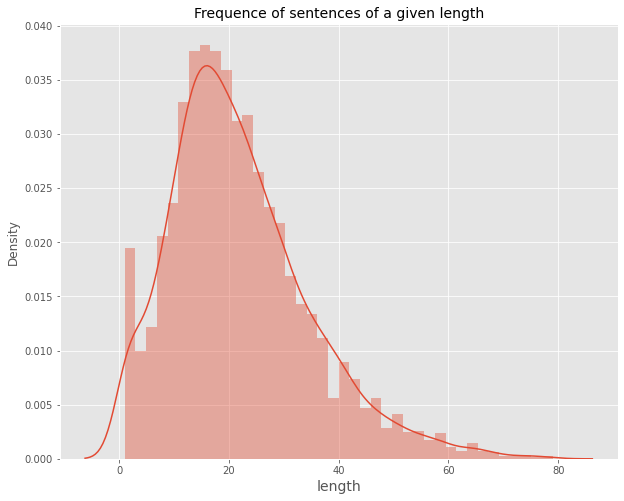

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train_data['length'] = train_data['original_text'].apply(lambda x: len(x.split()))
sns.distplot(train_data[train_data['length'] < 5000]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [12]:
# BERT token length should not be more than 512.
data_describe=train_data['original_text'].apply(lambda x: len(x.split())).describe()
print(data_describe)
MAX_SEQ_LENGTH=int(data_describe['max'])
if MAX_SEQ_LENGTH>512:
    MAX_SEQ_LENGTH=512

count    4168.000000
mean       21.913628
std        12.775337
min         1.000000
25%        13.000000
50%        20.000000
75%        29.000000
max        79.000000
Name: original_text, dtype: float64


In [13]:
#Create train, dev, test data
df_init,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(train_data,random_state=RANDOM_STATE)



{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417


In [14]:
params={
        "GRADIENT_ACCUMULATION_STEPS":1,
        "NUM_TRAIN_EPOCHS":8,
        "LEARNING_RATE":2e-5,
        "WARMUP_PROPORTION":0.1,
        "MAX_GRAD_NORM":5,
        "MAX_SEQ_LENGTH":MAX_SEQ_LENGTH,
        "BATCH_SIZE":16,
        "NUM_WARMUP_STEPS":600
}
BERT_MODEL = "distilbert-base-uncased"

##### Initial accuracy for pretrain model

In [15]:
_,init_pred,init_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=False,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.47002398081534774, 0.47002398081534774, 0.47002398081534774, None)
              precision    recall  f1-score   support

           0       0.47      0.98      0.64       196
           1       0.50      0.01      0.03       221

    accuracy                           0.47       417
   macro avg       0.48      0.50      0.33       417
weighted avg       0.49      0.47      0.31       417



##### Train model without any preprocessing.

In [16]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6186180785298347


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:46, 40.88s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6186180785298347]
Dev loss: 0.6083229954044024


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:05, 40.85s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:02<03:24, 40.81s/it]

Loss history: [0.6186180785298347, 0.6083229954044024]
Dev loss: 0.6732497451206049


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:43<04:32, 54.49s/it]

Loss history: [0.6186180785298347, 0.6083229954044024, 0.6732497451206049]
Dev loss: 1.0036601883669694
No improvement on development set. Finish training.


##### Accuracy after training

In [17]:
_,orig_pred,orig_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6690647482014388, 0.6690647482014388, 0.6690647482014388, None)
              precision    recall  f1-score   support

           0       0.62      0.74      0.68       196
           1       0.72      0.61      0.66       221

    accuracy                           0.67       417
   macro avg       0.67      0.67      0.67       417
weighted avg       0.68      0.67      0.67       417



In [18]:
# Assign those for future error analysis
orig_train_texts,orig_train_labels=train_texts,train_labels
orig_dev_texts,orig_dev_labels=dev_texts,dev_labels
orig_test_texts,orig_test_labels=test_texts,test_labels

##### Remove stopwords

In [19]:
from text_preprocessing import preprocess_text
from text_preprocessing import remove_punctuation,remove_special_character,normalize_unicode,check_spelling,remove_stopword,lemmatize_word
# Preprocess text using custom preprocess functions in the pipeline 
#STOPWORDS=['-RRB-','-LRB-'] # remove customized stopwords
#preprocess_functions = [to_lower, remove_punctuation,remove_special_character,normalize_unicode,remove_stopword,lemmatize_word]


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
process_data=train_data.copy()
process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(remove_stopword(x)))

In [21]:
process_data

,original_text,label,length
314316,"The Yarra Trams fleet consists 500 trams , ope...",0,18
136396,"Still Life concept album , explained Åkerfeldt...",1,39
377680,"Romana , short Romanadvoratrelundar , fictiona...",0,20
280270,A minor scale music theory scale least three s...,0,35
285587,The show also created character Frasier Crane .,0,9
...,...,...,...
145077,"In paintball , bunker obstacle field play used...",1,25
35542,La Ferrière-Harang commune Calvados department...,1,17
238435,The British Rail Class 325 dual-voltage altern...,0,26
324621,When Palmengarten returned city 's control 196...,0,21


In [22]:
df_sw,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417


In [23]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6455226788918177


Epoch:  12%|█████████▋                                                                   | 1/8 [00:41<04:48, 41.15s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6455226788918177]
Dev loss: 0.5838496213157972


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:22<04:07, 41.22s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:03<03:25, 41.18s/it]

Loss history: [0.6455226788918177, 0.5838496213157972]
Dev loss: 0.6413037534803152


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:44<04:34, 54.87s/it]

Loss history: [0.6455226788918177, 0.5838496213157972, 0.6413037534803152]
Dev loss: 1.0052730677028496
No improvement on development set. Finish training.


In [24]:
_,sw_pred,sw_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6642685851318945, 0.6642685851318945, 0.6642685851318945, None)
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       196
           1       0.70      0.64      0.67       221

    accuracy                           0.66       417
   macro avg       0.67      0.67      0.66       417
weighted avg       0.67      0.66      0.66       417



##### Spelling correction 

In [25]:
process_data=train_data.copy()
process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(check_spelling(x)) if type(x)=='str' else x)

In [26]:
process_data

,original_text,label,length
314316,"The Yarra Trams fleet consists of 500 trams , ...",0,18
136396,"Still Life is a concept album , as explained b...",1,39
377680,"Romana , short for Romanadvoratrelundar , is a...",0,20
280270,A minor scale in music theory is any scale tha...,0,35
285587,The show also created the character Frasier Cr...,0,9
...,...,...,...
145077,"In paintball , a bunker is an obstacle on the ...",1,25
35542,La Ferrière-Harang is a commune in the Calvado...,1,17
238435,The British Rail Class 325 is a dual-voltage a...,0,26
324621,When the Palmengarten was returned to the city...,0,21


In [27]:
df_pc,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417


In [28]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.63196878383557


Epoch:  12%|█████████▋                                                                   | 1/8 [00:41<04:49, 41.41s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.63196878383557]
Dev loss: 0.5948475946982702


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:23<04:09, 41.53s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:04<03:27, 41.46s/it]

Loss history: [0.63196878383557, 0.5948475946982702]
Dev loss: 0.6735671348869801


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:45<04:36, 55.24s/it]

Loss history: [0.63196878383557, 0.5948475946982702, 0.6735671348869801]
Dev loss: 0.9014609083533287
No improvement on development set. Finish training.


In [29]:
_,pc_pred,pc_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6714628297362111, 0.6714628297362111, 0.6714628297362111, None)
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       196
           1       0.70      0.67      0.69       221

    accuracy                           0.67       417
   macro avg       0.67      0.67      0.67       417
weighted avg       0.67      0.67      0.67       417



##### Lemmatization 

In [30]:
process_data=train_data.copy()
process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(lemmatize_word(x)))

In [31]:
process_data['original_text']

314316    The Yarra Trams fleet consists of 500 tram , o...
136396    Still Life is a concept album , a explained by...
377680    Romana , short for Romanadvoratrelundar , is a...
280270    A minor scale in music theory is any scale tha...
285587    The show also created the character Frasier Cr...
                                ...                        
145077    In paintball , a bunker is an obstacle on the ...
35542     La Ferrière-Harang is a commune in the Calvado...
238435    The British Rail Class 325 is a dual-voltage a...
324621    When the Palmengarten wa returned to the city ...
38232     Pong -LRB- marketed a PONG -RRB- is one of the...
Name: original_text, Length: 4168, dtype: object

In [32]:
df_lm,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417


In [33]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6214689078430334


Epoch:  12%|█████████▋                                                                   | 1/8 [00:41<04:49, 41.38s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  25%|███████████████████▎                                                         | 2/8 [01:22<04:07, 41.18s/it]

Loss history: [0.6214689078430334]
Dev loss: 0.644198402762413


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  25%|███████████████████▎                                                         | 2/8 [02:03<06:11, 61.90s/it]

Loss history: [0.6214689078430334, 0.644198402762413]
Dev loss: 0.7345572244375944
No improvement on development set. Finish training.


In [34]:
_,lm_pred,lm_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6546762589928058, 0.6546762589928058, 0.6546762589928058, None)
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       196
           1       0.67      0.69      0.68       221

    accuracy                           0.65       417
   macro avg       0.65      0.65      0.65       417
weighted avg       0.65      0.65      0.65       417



##### Check the duplicated data and create the data set without duplicates

In [35]:
train_data_unique=train_data.copy()
train_data_unique['duplicated']=train_data_unique.duplicated(subset=['original_text'])
#train_data_unique=train_data[train_data['duplicated']==False]
#print("Duplicated records: %.2f%%" %(100*(len(train_data)-len(train_data_unique))/len(train_data)))

In [36]:
train_data_unique

,original_text,label,length,duplicated
314316,"The Yarra Trams fleet consists of 500 trams , ...",0,18,False
136396,"Still Life is a concept album , as explained b...",1,39,False
377680,"Romana , short for Romanadvoratrelundar , is a...",0,20,False
280270,A minor scale in music theory is any scale tha...,0,35,False
285587,The show also created the character Frasier Cr...,0,9,False
...,...,...,...,...
145077,"In paintball , a bunker is an obstacle on the ...",1,25,False
35542,La Ferrière-Harang is a commune in the Calvado...,1,17,False
238435,The British Rail Class 325 is a dual-voltage a...,0,26,False
324621,When the Palmengarten was returned to the city...,0,21,False


In [37]:
process_data=train_data_unique.copy()
process_data=process_data[(process_data['duplicated']==False)]

In [38]:
df_dup,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3319
Dev size: 369
Test size: 410


In [39]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6572580635547638


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:43, 40.57s/it]

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6572580635547638]
Dev loss: 0.5631706981609265


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:20<04:02, 40.42s/it]

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:21, 40.38s/it]

Loss history: [0.6572580635547638, 0.5631706981609265]
Dev loss: 0.573878655831019


Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:29, 53.84s/it]

Loss history: [0.6572580635547638, 0.5631706981609265, 0.573878655831019]
Dev loss: 0.8223935291171074
No improvement on development set. Finish training.


In [40]:
_,dup_pred,dup_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/26 [00:00<?, ?it/s]

Errors performance: (0.6707317073170732, 0.6707317073170732, 0.6707317073170732, None)
              precision    recall  f1-score   support

           0       0.67      0.66      0.66       201
           1       0.67      0.68      0.68       209

    accuracy                           0.67       410
   macro avg       0.67      0.67      0.67       410
weighted avg       0.67      0.67      0.67       410



##### Remove the records which have the different labels
The sentences with different labels should impact the train performance as well as prediction results 

In [41]:
# look for the records with different labels 
def duple_labels(data):
    df_by=pd.DataFrame(data.groupby(['original_text','label']).count().reset_index()[["original_text","label"]])
    df_by=df_by.groupby(by='original_text').count().sort_values('label',ascending=False).reset_index()
    diff_labels=df_by[df_by['label']>1]
    print("Records with different labels: %.2f%%" %(100*len(diff_labels)/len(data)))
    return diff_labels

In [42]:
df_duple_labels=duple_labels(train_data)

Records with different labels: 0.02%


In [43]:
# Indentify double labels in data
train_data_unique=train_data_unique.merge(df_duple_labels,how="left",left_on="original_text",right_on="original_text")
train_data_unique['label_y']=train_data_unique['label_y'].apply(lambda x: '0' if pd.isnull(x) else '1') # 0 means 1 label, 1 means 2 labels
train_data_unique=pd.DataFrame(train_data_unique[['original_text','label_x','label_y','duplicated']])
train_data_unique.columns=['original_text','label','dulabel','duplicated']

In [44]:
train_data_unique

,original_text,label,dulabel,duplicated
0,"The Yarra Trams fleet consists of 500 trams , ...",0,0,False
1,"Still Life is a concept album , as explained b...",1,0,False
2,"Romana , short for Romanadvoratrelundar , is a...",0,0,False
3,A minor scale in music theory is any scale tha...,0,0,False
4,The show also created the character Frasier Cr...,0,0,False
...,...,...,...,...
4163,"In paintball , a bunker is an obstacle on the ...",1,0,False
4164,La Ferrière-Harang is a commune in the Calvado...,1,0,False
4165,The British Rail Class 325 is a dual-voltage a...,0,0,False
4166,When the Palmengarten was returned to the city...,0,0,False


##### Accuracy of removing records with duplicate text or different label

In [45]:
process_data=train_data_unique.copy()
process_data=process_data[(process_data['dulabel']=='0')]

In [46]:
process_data

,original_text,label,dulabel,duplicated
0,"The Yarra Trams fleet consists of 500 trams , ...",0,0,False
1,"Still Life is a concept album , as explained b...",1,0,False
2,"Romana , short for Romanadvoratrelundar , is a...",0,0,False
3,A minor scale in music theory is any scale tha...,0,0,False
4,The show also created the character Frasier Cr...,0,0,False
...,...,...,...,...
4163,"In paintball , a bunker is an obstacle on the ...",1,0,False
4164,La Ferrière-Harang is a commune in the Calvado...,1,0,False
4165,The British Rail Class 325 is a dual-voltage a...,0,0,False
4166,When the Palmengarten was returned to the city...,0,0,False


In [47]:
df_duo,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3373
Dev size: 375
Test size: 417


In [48]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6135546068350474


Epoch:  12%|█████████▋                                                                   | 1/8 [00:41<04:49, 41.35s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6135546068350474]
Dev loss: 0.5786453348894914


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:22<04:08, 41.45s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:04<03:27, 41.41s/it]

Loss history: [0.6135546068350474, 0.5786453348894914]
Dev loss: 0.5971092892189821


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:44<04:34, 54.99s/it]

Loss history: [0.6135546068350474, 0.5786453348894914, 0.5971092892189821]
Dev loss: 0.8266282541056474
No improvement on development set. Finish training.


In [49]:
_,duo_pred,duo_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.697841726618705, 0.697841726618705, 0.697841726618705, None)
              precision    recall  f1-score   support

           0       0.76      0.57      0.66       209
           1       0.66      0.82      0.73       208

    accuracy                           0.70       417
   macro avg       0.71      0.70      0.69       417
weighted avg       0.71      0.70      0.69       417



##### Compare the results from different text processing

In [50]:
df_acc=pd.DataFrame(columns=['description','accuracy'])
df_acc['description']=['Pretrain','Fine tune without preprocessing',
                       'Removal of stopwords','Correction of spelling',
                      'Lemmatization','Removal of duplicate records',
                      'Removal of mislabeling']
df_acc['accuracy']=[init_acc,orig_acc,sw_acc,pc_acc,lm_acc,dup_acc,duo_acc]

<AxesSubplot:xlabel='accuracy', ylabel='description'>

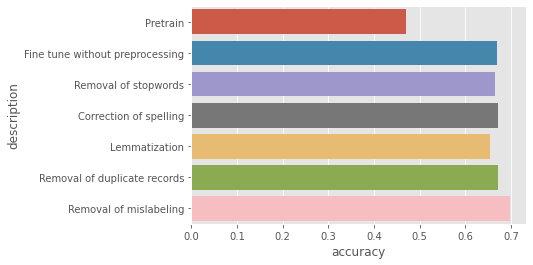

In [51]:
sns.barplot(data=df_acc, y="description", x="accuracy")

##### Impact investigation on similar text

In [52]:
df_test=pd.DataFrame(columns=['original_text','label','err','init_pred','best_pred','cnt_1','cnt_0','avg_1','avg_0'])

In [54]:
df_test['original_text']=orig_test_texts
df_test['label']=orig_test_labels
df_test['init_pred']=init_pred
df_test['best_pred']=orig_pred
df_test['err']=df_test['best_pred']-df_test['label']
df_test['err']=df_test['err'].apply(lambda x: 1 if x!=0 else x)

In [55]:
df_test

,original_text,label,err,init_pred,best_pred,cnt_1,cnt_0,avg_1,avg_0
0,Maroon 5 and Rihanna performed it for the firs...,1,1,0,0,NaN,NaN,NaN,NaN
1,"The son of Jean-Marc Vacheron , Abraham , beca...",0,0,0,0,NaN,NaN,NaN,NaN
2,"Younha performed the song Diamonds , which was...",0,0,0,0,NaN,NaN,NaN,NaN
3,Baby blue is known as one of the pastel colors...,0,0,0,0,NaN,NaN,NaN,NaN
4,Established in 1960 in response to increasing ...,1,0,0,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
412,It is found in the region Aquitaine in the Gir...,0,0,0,0,NaN,NaN,NaN,NaN
413,"Span -LRB- architecture -RRB- , a section betw...",1,1,0,0,NaN,NaN,NaN,NaN
414,Carême gained fame in Paris for his cake centr...,0,1,0,1,NaN,NaN,NaN,NaN
415,ThÃ lus is a commune . It is found in the regi...,0,0,0,0,NaN,NaN,NaN,NaN


##### Display the length of test data and error data in test set

Text(0.5, 0, 'length')

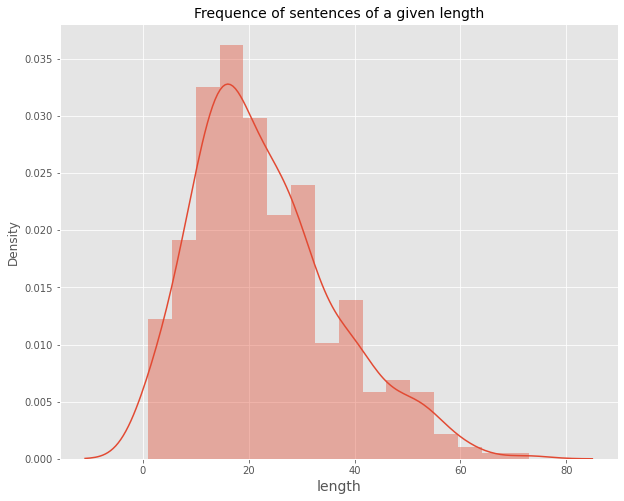

In [56]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df_test['length'] = df_test['original_text'].apply(lambda x: len(x.split()))
sns.distplot(df_test[df_test['length'] < 5000]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

Text(0.5, 0, 'length')

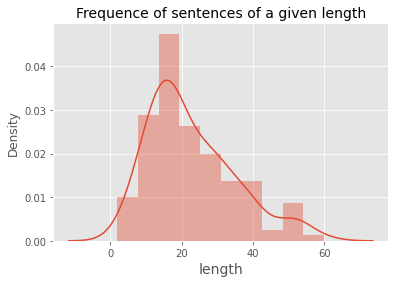

In [57]:
sns.distplot(df_test[(df_test['length'] < 5000) & (df_test['err']==1)]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [58]:
from sentence_transformers import SentenceTransformer
onlinemodel='all-mpnet-base-v2'
embedder = SentenceTransformer(onlinemodel)

10/24/2022 12:59:59 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: all-mpnet-base-v2
10/24/2022 13:00:00 - INFO - sentence_transformers.SentenceTransformer -   Use pytorch device: cuda


In [59]:
from sklearn.metrics.pairwise import cosine_similarity
# work out the similarity and identify the record of self
#str_to_predict=df_test['original_text'].iloc[11]
#print(str_to_predict)
query_embeddings=embedder.encode(df_test['original_text'])
#sim=cosine_similarity([embedder.encode(str_to_predict)],query_embeddings)
#j=np.argmax(sim)
#sim.argsort()[-3:][::-1][0][:-1]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Compare the embeddings between error records in test set with training set + test set ( including error record), find out the similar 
records,display the numbers of different labels to check whether the portion of label could impact the classification records.

In [60]:
#Create the dataset for comparison,remove duplicate and different label
#df_train=train_data_unique[(train_data_unique['duplicated']==False) | (train_data_unique['dulabel']=='0')]
df_train=train_data_unique.copy()
df_comp=pd.concat([pd.DataFrame(df_train[['original_text','label']]),pd.DataFrame()],
                  ignore_index=True)

#Assign the index to identify each row
#df_comp=df_train.copy()
df_comp=df_comp.reset_index()


# Create the embedding for comparison dataset
query_embeddings=embedder.encode(df_comp['original_text'])

Batches:   0%|          | 0/131 [00:00<?, ?it/s]

In [61]:
df_test['id']=df_test.index
df_test['id']=df_test['id'].apply(lambda x: 'e'+str(x))

In [62]:
df_test

,original_text,label,err,init_pred,best_pred,cnt_1,cnt_0,avg_1,avg_0,length,id
0,Maroon 5 and Rihanna performed it for the firs...,1,1,0,0,NaN,NaN,NaN,NaN,26,e0
1,"The son of Jean-Marc Vacheron , Abraham , beca...",0,0,0,0,NaN,NaN,NaN,NaN,18,e1
2,"Younha performed the song Diamonds , which was...",0,0,0,0,NaN,NaN,NaN,NaN,19,e2
3,Baby blue is known as one of the pastel colors...,0,0,0,0,NaN,NaN,NaN,NaN,22,e3
4,Established in 1960 in response to increasing ...,1,0,0,1,NaN,NaN,NaN,NaN,54,e4
...,...,...,...,...,...,...,...,...,...,...,...
412,It is found in the region Aquitaine in the Gir...,0,0,0,0,NaN,NaN,NaN,NaN,17,e412
413,"Span -LRB- architecture -RRB- , a section betw...",1,1,0,0,NaN,NaN,NaN,NaN,11,e413
414,Carême gained fame in Paris for his cake centr...,0,1,0,1,NaN,NaN,NaN,NaN,18,e414
415,ThÃ lus is a commune . It is found in the regi...,0,0,0,0,NaN,NaN,NaN,NaN,23,e415


In [63]:
# Set the simlarity threshold 
THRESHOLD=0.5

#Create dateset to cluster the similar sentence
err_cluster=pd.DataFrame(columns=list(df_comp.columns)+['score','cluster'])

df_err=df_test[df_test['err']==1]
for i in trange(len(df_err)):
    #print(df_test[df_test['err']==1]['original_text'].iloc[i])
    df_temp=pd.DataFrame(columns=err_cluster.columns)
    str_to_predict=df_test[df_test['err']==1]['original_text'].iloc[i]
    #print(str_to_predict)
    sim=cosine_similarity([embedder.encode(str_to_predict)],query_embeddings)
    j=np.argmax(sim)
    sim_rows=list(np.where(sim[0]>THRESHOLD)[0])
    if sim_rows !=[]:
        #print(set(np.where(sim[0]>THRESHOLD)[0]))
        
        if err_cluster.empty:
            df_temp=df_comp.iloc[sim_rows]
        else:
            #print(set(err_cluster['index']))
            #df_temp=df_comp.iloc[list(set(sim_rows)-set(list(err_cluster['index'])))]
            df_temp=df_comp.iloc[sim_rows]
            # (df_temp)
        
        if df_temp.empty== False:
            #print(sim[0][sim_rows])
            df_temp['score']=sim[0][sim_rows]
            df_temp['cluster']=df_err['id'].iloc[i]
            
            
            err_cluster=pd.concat([err_cluster,df_temp],axis=0,ignore_index=True)
            #print(df_temp)

  0%|                                                                                          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  2%|█▊                                                                                | 3/138 [00:00<00:05, 25.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  4%|███▌                                                                              | 6/138 [00:00<00:04, 27.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  7%|█████▎                                                                            | 9/138 [00:00<00:04, 28.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  9%|███████                                                                          | 12/138 [00:00<00:04, 28.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 11%|████████▊                                                                        | 15/138 [00:00<00:04, 28.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 13%|██████████▌                                                                      | 18/138 [00:00<00:04, 28.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 15%|████████████▎                                                                    | 21/138 [00:00<00:04, 28.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 17%|██████████████                                                                   | 24/138 [00:00<00:03, 29.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 20%|████████████████▍                                                                | 28/138 [00:00<00:03, 29.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 22%|██████████████████▏                                                              | 31/138 [00:01<00:03, 29.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 25%|███████████████████▉                                                             | 34/138 [00:01<00:03, 28.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 27%|█████████████████████▋                                                           | 37/138 [00:01<00:03, 28.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 29%|███████████████████████▍                                                         | 40/138 [00:01<00:03, 28.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 31%|█████████████████████████▏                                                       | 43/138 [00:01<00:03, 29.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 33%|███████████████████████████                                                      | 46/138 [00:01<00:03, 29.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 36%|████████████████████████████▊                                                    | 49/138 [00:01<00:03, 28.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 38%|██████████████████████████████▌                                                  | 52/138 [00:01<00:02, 28.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 40%|████████████████████████████████▎                                                | 55/138 [00:01<00:02, 29.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 42%|██████████████████████████████████                                               | 58/138 [00:02<00:02, 27.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 44%|███████████████████████████████████▊                                             | 61/138 [00:02<00:02, 27.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 47%|██████████████████████████████████████▏                                          | 65/138 [00:02<00:02, 27.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 49%|███████████████████████████████████████▉                                         | 68/138 [00:02<00:02, 27.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 51%|█████████████████████████████████████████▋                                       | 71/138 [00:02<00:02, 26.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 54%|███████████████████████████████████████████▍                                     | 74/138 [00:02<00:02, 27.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 56%|█████████████████████████████████████████████▏                                   | 77/138 [00:02<00:02, 27.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 58%|██████████████████████████████████████████████▉                                  | 80/138 [00:02<00:02, 27.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 60%|████████████████████████████████████████████████▋                                | 83/138 [00:02<00:01, 27.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 62%|██████████████████████████████████████████████████▍                              | 86/138 [00:03<00:01, 26.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 64%|████████████████████████████████████████████████████▏                            | 89/138 [00:03<00:01, 27.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 67%|██████████████████████████████████████████████████████                           | 92/138 [00:03<00:01, 27.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 69%|███████████████████████████████████████████████████████▊                         | 95/138 [00:03<00:01, 27.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 71%|█████████████████████████████████████████████████████████▌                       | 98/138 [00:03<00:01, 26.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 73%|██████████████████████████████████████████████████████████▌                     | 101/138 [00:03<00:01, 25.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 75%|████████████████████████████████████████████████████████████▎                   | 104/138 [00:03<00:01, 25.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 78%|██████████████████████████████████████████████████████████████                  | 107/138 [00:03<00:01, 26.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 80%|███████████████████████████████████████████████████████████████▊                | 110/138 [00:03<00:01, 25.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 82%|█████████████████████████████████████████████████████████████████▌              | 113/138 [00:04<00:00, 26.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 84%|███████████████████████████████████████████████████████████████████▏            | 116/138 [00:04<00:00, 26.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 86%|████████████████████████████████████████████████████████████████████▉           | 119/138 [00:04<00:00, 26.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 88%|██████████████████████████████████████████████████████████████████████▋         | 122/138 [00:04<00:00, 25.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 91%|████████████████████████████████████████████████████████████████████████▍       | 125/138 [00:04<00:00, 25.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 93%|██████████████████████████████████████████████████████████████████████████▏     | 128/138 [00:04<00:00, 25.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 95%|███████████████████████████████████████████████████████████████████████████▉    | 131/138 [00:04<00:00, 25.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 97%|█████████████████████████████████████████████████████████████████████████████▋  | 134/138 [00:04<00:00, 25.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 99%|███████████████████████████████████████████████████████████████████████████████▍| 137/138 [00:05<00:00, 25.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_5908\2028418517.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:05<00:00, 27.21it/s]


In [64]:
err_cluster

,index,original_text,label,score,cluster
0,1217,Maroon 5 and Rihanna performed it for the firs...,1,1.000000,e0
1,1912,"It was a commercial success , topping the U.S....",0,0.504141,e0
2,2633,He first performed the song at the MTV Video M...,0,0.519398,e0
3,4040,The song was part of the set list of Knowles '...,1,0.511458,e0
4,678,"Nevertheless , it was a relative hit in Europe...",0,1.000000,e6
...,...,...,...,...,...
297,955,Concubines have limited rights of support from...,1,0.699902,e406
298,1459,Kung Fu Panda 2 -LRB- originally Kung Fu Panda...,1,1.000000,e409
299,3816,"Span -LRB- architecture -RRB- , a section betw...",1,1.000000,e413
300,746,Carême gained fame in Paris for his pièces mon...,1,0.780434,e414


In [65]:
#Display the records whose similar recods have 2 diferent labels
df_group=err_cluster.groupby(['cluster','label']).count().reset_index().groupby('cluster').count()
df_group[df_group['label']>1]

,label,index,original_text,score
cluster,,,,
e0,2,2,2,2
e103,2,2,2,2
e119,2,2,2,2
e120,2,2,2,2
e135,2,2,2,2
e146,2,2,2,2
e150,2,2,2,2
e158,2,2,2,2
e159,2,2,2,2


In [66]:
err_cluster[err_cluster['cluster']=='e100']

,index,original_text,label,score,cluster


In [67]:
df_err[df_err['id']=='e100']

,original_text,label,err,init_pred,best_pred,cnt_1,cnt_0,avg_1,avg_0,length,id


Change label and retrain the model ,see whether it could impact the evluation result.

In [68]:
#Create train, dev, test data
df_comp.iloc[4088]

index                                                      4088
original_text    It is often called wine red , or simply wine .
label                                                         1
Name: 4088, dtype: object

In [69]:
df_comp.at[4088,'label']=0

In [70]:
df_comp.at[4088,'label']

0

In [71]:
orig_train_text=df_comp['original_text']
orig_train_label=df_comp['label']

In [72]:
train(BERT_MODEL,orig_train_texts,orig_train_labels,orig_dev_texts,orig_dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.611780354132255


Epoch:  12%|█████████▋                                                                   | 1/8 [00:41<04:47, 41.07s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.611780354132255]
Dev loss: 0.5871045961976051


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:22<04:06, 41.12s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:03<03:25, 41.04s/it]

Loss history: [0.611780354132255, 0.5871045961976051]
Dev loss: 0.6083705822626749


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:44<04:33, 54.71s/it]

Loss history: [0.611780354132255, 0.5871045961976051, 0.6083705822626749]
Dev loss: 0.9325737080847224
No improvement on development set. Finish training.


In [73]:
_,orig_pred,orig_acc=data_evaluation(orig_test_texts,orig_test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6906474820143885, 0.6906474820143885, 0.6906474820143885, None)
              precision    recall  f1-score   support

           0       0.73      0.54      0.62       196
           1       0.67      0.82      0.74       221

    accuracy                           0.69       417
   macro avg       0.70      0.68      0.68       417
weighted avg       0.70      0.69      0.68       417



In [74]:
orig_test_texts[100],orig_pred[100]

('They can be made from white Chardonnay grapes , or red Pinot Noir or Pinot Meunier grapes .',
 0)

Apparently, after chaning one record's label from 1 to 0, the result of evaluation is changed as well.
Let's change the label back, and take further test again.

In [75]:
df_comp.at[4088,'label']=1

In [76]:
df_comp.at[4088,'label']

1

In [77]:
err_cluster[err_cluster['cluster']=='e9']

,index,original_text,label,score,cluster
7,642,Despite being a villain for most of his career...,1,0.542308,e9
8,2350,After being trained at the Texas Wrestling Aca...,0,1.000000,e9
9,3467,After being trained at the Texas Wrestling Aca...,1,0.999308,e9


In [78]:
df_err[df_err['id']=='e9']

,original_text,label,err,init_pred,best_pred,cnt_1,cnt_0,avg_1,avg_0,length,id
9,After being trained at the Texas Wrestling Aca...,0,1,0,1,NaN,NaN,NaN,NaN,38,e9


In [79]:
df_comp.at[3467,'label']=0
df_comp.at[642,'label']=0

In [80]:
df_comp.at[3467,'label'],df_comp.at[642,'label']

(0, 0)

In [81]:
orig_train_text=df_comp['original_text']
orig_train_label=df_comp['label']

In [82]:
train(BERT_MODEL,orig_train_texts,orig_train_labels,orig_dev_texts,orig_dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.65594199548165


Epoch:  12%|█████████▋                                                                   | 1/8 [00:41<04:48, 41.23s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.65594199548165]
Dev loss: 0.6155034142235914


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:22<04:07, 41.27s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:03<03:26, 41.21s/it]

Loss history: [0.65594199548165, 0.6155034142235914]
Dev loss: 0.6427479249735674


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:44<04:34, 54.87s/it]

Loss history: [0.65594199548165, 0.6155034142235914, 0.6427479249735674]
Dev loss: 0.8693114692966143
No improvement on development set. Finish training.


In [83]:
_,orig_pred,orig_acc=data_evaluation(orig_test_texts,orig_test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6402877697841727, 0.6402877697841727, 0.6402877697841727, None)
              precision    recall  f1-score   support

           0       0.59      0.78      0.67       196
           1       0.73      0.52      0.60       221

    accuracy                           0.64       417
   macro avg       0.66      0.65      0.64       417
weighted avg       0.66      0.64      0.64       417



In [84]:
orig_test_texts[9],orig_pred[9]

('After being trained at the Texas Wrestling Academy , London began competing for Ring of Honor , where although he never won a title , began popular amongst the fans due to his high risk offensive moves .',
 1)

In [85]:
err_cluster[err_cluster['cluster']=='e103']

,index,original_text,label,score,cluster
57,816,1847 & ndash ; Whitman Massacre : Missionaries...,1,0.509415,e103
58,3090,1804 - Lewis and Clark Expedition : The '' Cor...,0,1.000000,e103


In [86]:
df_err[df_err['id']=='e103']

,original_text,label,err,init_pred,best_pred,cnt_1,cnt_0,avg_1,avg_0,length,id
103,1804 - Lewis and Clark Expedition : The '' Cor...,0,1,0,1,NaN,NaN,NaN,NaN,34,e103


In [87]:
err_cluster[err_cluster['cluster']=='e111']

,index,original_text,label,score,cluster


In [88]:
df_err[df_err['id']=='e111']

,original_text,label,err,init_pred,best_pred,cnt_1,cnt_0,avg_1,avg_0,length,id


##### Final report 5.3 - Unsupervised learning

Step 1. Create dataset for unsupervised learning

In [89]:
# Create the embedding for comparison dataset
df_train=train_data_unique.copy()
df_train['type']='train'
df_train['err']='0'
df_test['type']='test'
df_cluster=pd.concat([pd.DataFrame(df_train[['original_text','label','type','err']]),
                   pd.DataFrame(df_test[['original_text','label','type','err']])],
                  ignore_index=True)

#Assign the index to identify each row
df_cluster=df_cluster.reset_index()


Step 2. Using sentence-BERT to create the embeddings.

In [90]:
cluster_embeddings=embedder.encode(df_cluster['original_text'])

Batches:   0%|          | 0/144 [00:00<?, ?it/s]

Step 3. Run PCA

In [91]:
# Clustering algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(cluster_embeddings)

In [92]:
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['sentence_id']=df_cluster.index

Step 4. Run Elbow method to find out optimal K.

In [93]:
# Elbow criterion - Determine optimal numbers of clusters by elbow rule.
def elbow_plot(data, maxK=15, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = []
    K= range(1, maxK)
    for k in K:
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            #data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            #data["clusters"] = kmeans.labels_
        print("k: ", k,"sse: ",kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(K,sse,'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return kmeans.labels_

k:  1 sse:  217.525390625
k:  2 sse:  127.7337417602539
k:  3 sse:  75.12358093261719
k:  4 sse:  56.58615493774414
k:  5 sse:  46.125267028808594
k:  6 sse:  39.87982940673828
k:  7 sse:  34.718746185302734
k:  8 sse:  30.622573852539062
k:  9 sse:  27.420618057250977
k:  10 sse:  25.042747497558594
k:  11 sse:  23.13288116455078
k:  12 sse:  21.386571884155273
k:  13 sse:  19.8399600982666
k:  14 sse:  18.529178619384766


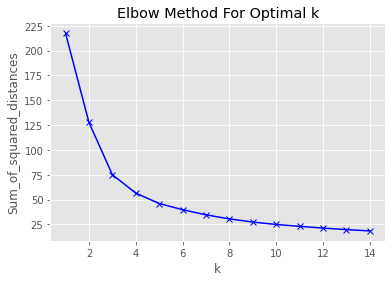

array([11,  4, 12, ...,  8,  3, 12])

In [94]:
# Run Elbow for full training data
elbow_plot(principalComponents,maxK=15)

Step 5. Run Kmeans to cluster the embeddings

In [95]:
num_clusters = 2
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(cluster_embeddings)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":df_cluster.iloc[i]['original_text'],
                                "label":df_cluster.iloc[i]['label'],
                                "err":str(df_cluster.iloc[i]['err'])
                           }
                            )
    cdf=cdf.append(new_row,ignore_index=True)

cdf.head()

,cluster_id,sentence_id,sentence,err,label
0,0,0,"The Yarra Trams fleet consists of 500 trams , ...",0,0.0
1,1,1,"Still Life is a concept album , as explained b...",0,1.0
2,1,2,"Romana , short for Romanadvoratrelundar , is a...",0,0.0
3,0,3,A minor scale in music theory is any scale tha...,0,0.0
4,1,4,The show also created the character Frasier Cr...,0,0.0


In [96]:
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence_id'],left_on=['sentence_id'])

In [97]:
df_k

,principal component 1,principal component 2,sentence_id,cluster_id,sentence,err,label
0,-0.159446,0.043789,0,0,"The Yarra Trams fleet consists of 500 trams , ...",0,0.0
1,0.030641,-0.167391,1,1,"Still Life is a concept album , as explained b...",0,1.0
2,0.072480,-0.006303,2,1,"Romana , short for Romanadvoratrelundar , is a...",0,0.0
3,-0.135785,-0.134344,3,0,A minor scale in music theory is any scale tha...,0,0.0
4,0.133530,-0.097004,4,1,The show also created the character Frasier Cr...,0,0.0
...,...,...,...,...,...,...,...
4580,-0.367938,0.333102,4580,0,It is found in the region Aquitaine in the Gir...,0,0.0
4581,-0.104363,0.005071,4581,0,"Span -LRB- architecture -RRB- , a section betw...",1,1.0
4582,-0.000467,0.047556,4582,1,Carême gained fame in Paris for his cake centr...,1,0.0
4583,-0.227628,0.162292,4583,0,ThÃ lus is a commune . It is found in the regi...,0,0.0


Step 6. Plot clustering results

In [98]:
import altair as alt

alt.Chart(df_k).mark_point(size=60).encode(
    x='principal component 1',
    y='principal component 2',
    shape='err:N',
    color=alt.Color('cluster_id', scale=alt.Scale(scheme='category20c')),
    tooltip=['sentence','sentence_id','label']
).properties(title='PCA & Kmeans',height=400,width=500).interactive()

alt.Chart(...)

Using UMAP & HDBSCAN  

In [99]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=2, 
                            metric='cosine').fit_transform(cluster_embeddings)

In [100]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [101]:
umap_embeddings

array([[ 7.699079, 10.225445],
       [10.981952, 12.223752],
       [ 7.839553, 11.809188],
       ...,
       [ 7.944455, 12.354773],
       [ 2.425679, 10.937   ],
       [ 7.957601, 11.427633]], dtype=float32)

In [102]:
df_uh = pd.DataFrame(data = umap_embeddings
             , columns = ['UMAP component 1', 'UMAP component 2'])

df_uh['sentence_id']=df_cluster.index

In [103]:
uh_cluster_assignment = cluster.labels_

uh_cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(uh_cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":uh_cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":df_cluster.iloc[i]['original_text'],
                                "label":df_cluster.iloc[i]['label'],
                                "err":str(df_cluster.iloc[i]['err'])
                           }
                            )
    uh_cdf=uh_cdf.append(new_row,ignore_index=True)

uh_cdf.head()

,cluster_id,sentence_id,sentence,err,label
0,505,0,"The Yarra Trams fleet consists of 500 trams , ...",0,0.0
1,338,1,"Still Life is a concept album , as explained b...",0,1.0
2,-1,2,"Romana , short for Romanadvoratrelundar , is a...",0,0.0
3,316,3,A minor scale in music theory is any scale tha...,0,0.0
4,380,4,The show also created the character Frasier Cr...,0,0.0


In [104]:
# Combine PCA results with K-means results to see clustering
df_uh_c=df_uh.merge(uh_cdf,right_on=['sentence_id'],left_on=['sentence_id'])

In [105]:
alt.Chart(df_uh_c).mark_point(size=60).encode(
    x='UMAP component 1',
    y='UMAP component 2',
    shape='err:N',
    color=alt.Color('cluster_id', scale=alt.Scale(scheme='category20c')),
    tooltip=['sentence','label']
).properties(title='UMAP & HBDSCAN',height=400,width=500).interactive()

alt.Chart(...)

In [106]:
df_uh_c[df_uh_c['sentence_id']==4257]

,UMAP component 1,UMAP component 2,sentence_id,cluster_id,sentence,err,label
4257,4.788314,10.598452,4257,463,"Zeta -LRB- river -RRB- , in Montenegro",1,1.0
